<a href="https://colab.research.google.com/github/GerGoar/Image_Deep_Learning_Project/blob/main/Classifier_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; plat

In [2]:
## Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import libraries
!pip install datasets
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import zipfile
import shutil
from sklearn.model_selection import train_test_split
import random
from collections import Counter, defaultdict
from torchvision.datasets import ImageFolder
import pandas as pd
import seaborn as sns

In [4]:
# Loading the Dataset
# REMOVE any old copy
!rm -rf /content/FaceDataset

# Extract zip file from Google Drive
zip_path = "/content/drive/MyDrive/Deep Learning Applications/Full_DataSet.zip"
extract_path = "/content/FaceDataset"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
# Set random seeds for reproducibility
random.seed(8)
np.random.seed(8)
torch.manual_seed(8)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(8)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Check the structure
print("Dataset structure:")
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files)-5} more files")

# Find the actual dataset directory (adjust if needed)
dataset_dir = extract_path
if "Full DataSet" in os.listdir(extract_path):
    dataset_dir = os.path.join(extract_path, "Full DataSet")

print(f"\nUsing dataset directory: {dataset_dir}")

# Load dataset using HuggingFace datasets
dataset = load_dataset(
    "imagefolder",
    data_dir=dataset_dir,
)

print(dataset)
print(f"Number of classes: {len(dataset['train'].features['label'].names)}")
print(f"Class names: {dataset['train'].features['label'].names}")


Dataset structure:
FaceDataset/
  Full DataSet/
    Gerardo/
      IMG_3826_frame_668.jpg
      IMG_3836_frame_210.jpg
      IMG_3826_frame_640.jpg
      IMG_3834_frame_401.jpg
      IMG_3836_frame_178.jpg
      ... and 5478 more files
    Oliver/
      IMG_3827_frame_343.jpg
      IMG_3833_frame_1782.jpg
      IMG_3833_frame_1429.jpg
      IMG_3835_frame_1323.jpg
      IMG_3833_frame_941.jpg
      ... and 5441 more files
    Timothy/
      IMG_3832_frame_717.jpg
      IMG_3840_frame_1575.jpg
      IMG_3832_frame_733.jpg
      IMG_3840_frame_403.jpg
      IMG_3832_frame_899.jpg
      ... and 5542 more files
  __MACOSX/
    ._Full DataSet
    Full DataSet/
      ._Oliver
      ._Gerardo
      ._Timothy
      Gerardo/
        ._IMG_3836_frame_821.jpg
        ._IMG_3836_frame_1732.jpg
        ._IMG_3826_frame_259.jpg
        ._IMG_3834_frame_763.jpg
        ._IMG_3836_frame_1231.jpg
        ... and 5478 more files
      Oliver/
        ._IMG_3833_frame_978.jpg
        ._IMG_3827_frame_63.

Resolving data files:   0%|          | 0/16476 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 16476
    })
})
Number of classes: 3
Class names: ['Gerardo', 'Oliver', 'Timothy']


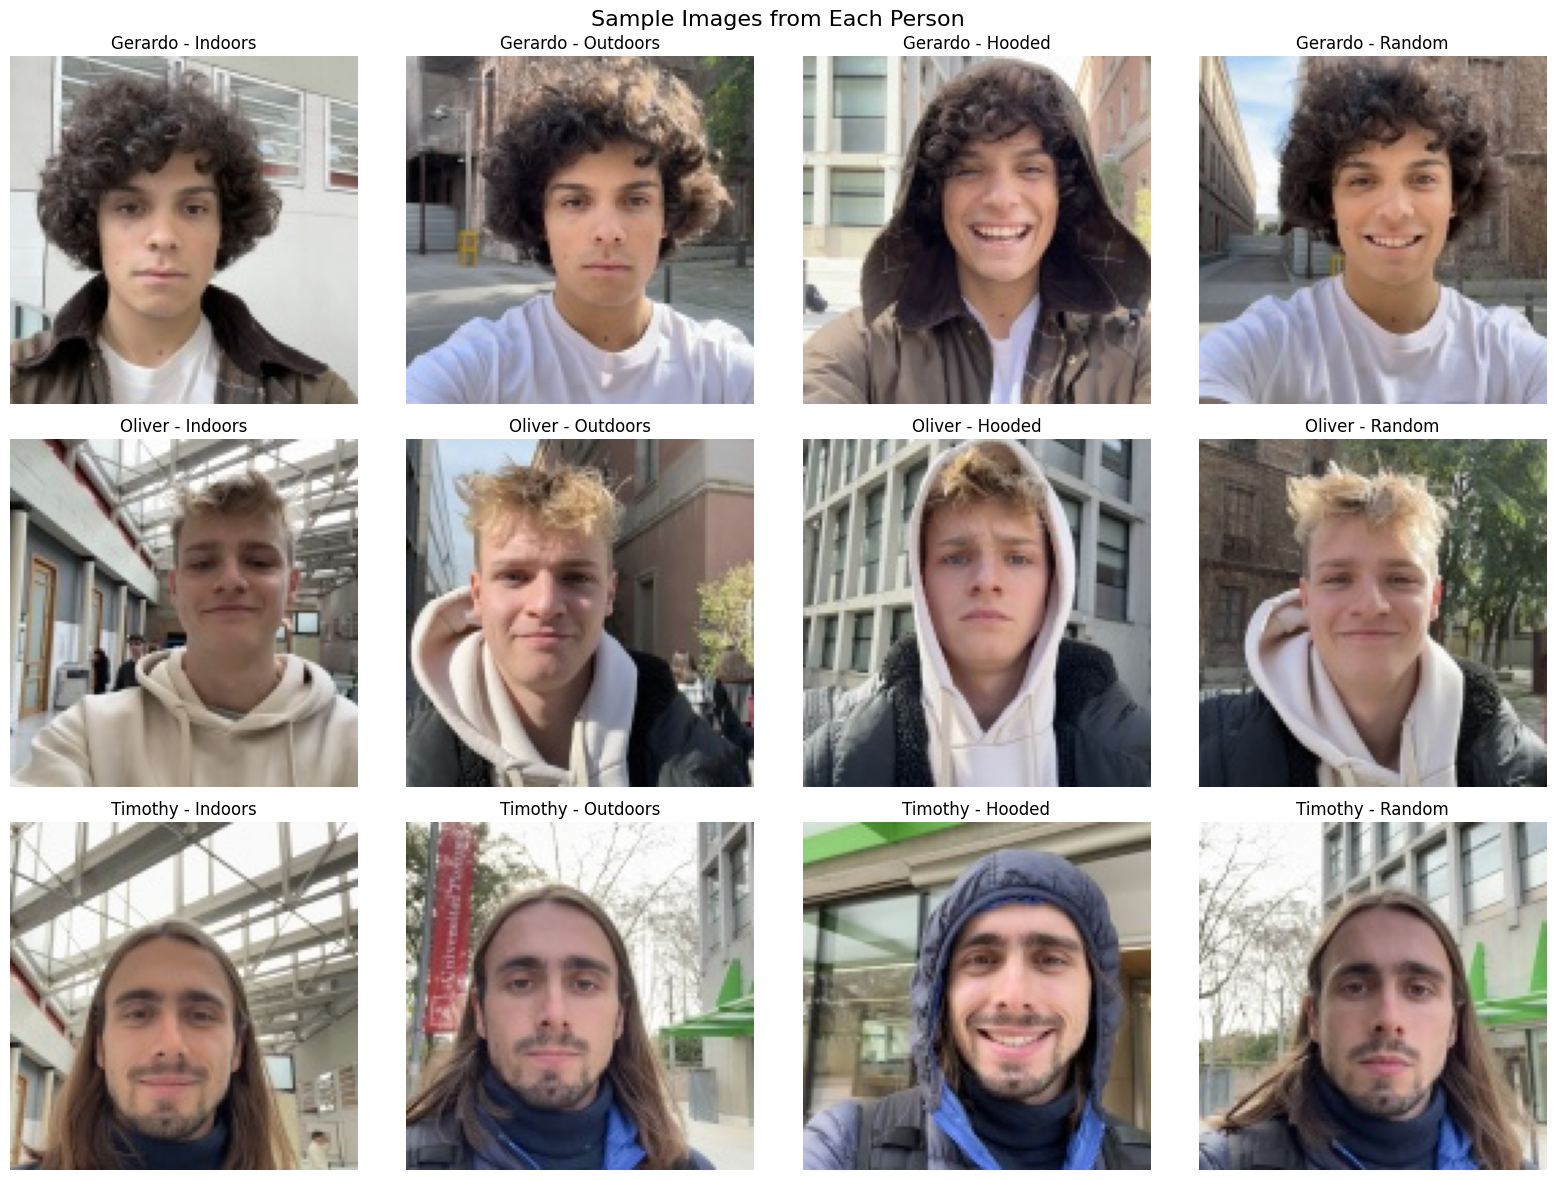


Dataset Statistics:
Gerardo: 5483 images
Oliver: 5446 images
Timothy: 5547 images


In [7]:
# Visualize some examples from each person
fig, axs = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Sample Images from Each Person', fontsize=16)

for person_idx in range(3):  # Gerardo, Oliver, Timo
    # Find images for this person
    person_images = [item for item in dataset["train"] if item["label"] == person_idx]
    person_name = dataset['train'].features['label'].names[person_idx]

    if len(person_images) > 0:
        # Calculate indices for beginning, middle, and end
        total_images = len(person_images)
        beginning_idx = 0
        middle_idx = total_images // 2
        end_idx = total_images - 1

        # Select a random index for the 4th image
        import random
        random_idx = random.randint(0, total_images - 1)

        # Define which images to show with labels
        sample_indices = [beginning_idx, middle_idx, end_idx, random_idx]
        sample_labels = ["Indoors", "Outdoors", "Hooded", "Random"]

        for i in range(4):
            if i < len(sample_indices):
                img_idx = sample_indices[i]
                axs[person_idx, i].imshow(person_images[img_idx]["image"])
                axs[person_idx, i].set_title(f"{person_name} - {sample_labels[i]}")
            axs[person_idx, i].set_axis_off()

plt.tight_layout()
plt.show()

# Print dataset statistics
print("\nDataset Statistics:")
for idx, name in enumerate(dataset['train'].features['label'].names):
    count = sum(1 for item in dataset["train"] if item["label"] == idx)
    print(f"{name}: {count} images")

In [31]:
# Define transformations with data augmentation for training
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),                                              # Standard input size for ResNet
    transforms.RandomHorizontalFlip(p=0.5),                                   # Random horizontal flip
    transforms.RandomRotation(degrees=10),                                      # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Color augmentation
    transforms.ToTensor(),                                                      # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create train-validation split
train_val_dataset = dataset["train"]
train_indices, val_indices = train_test_split(
    range(len(train_val_dataset)),
    test_size=0.2,
    stratify=[item['label'] for item in train_val_dataset],
    random_state=42
)

print(f"\nDataset split:")
print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")

# Create PyTorch Dataset class for faces
class FaceDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices=None, transform=None):
        self.dataset = dataset
        self.indices = indices if indices is not None else range(len(dataset))
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample = self.dataset[self.indices[idx]]
        image = sample['image']
        label = sample['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and dataloaders
train_dataset = FaceDataset(train_val_dataset, train_indices, transform_train)
val_dataset = FaceDataset(train_val_dataset, val_indices, transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print class distribution in train and validation sets
train_labels = [train_val_dataset[i]['label'] for i in train_indices]
val_labels = [train_val_dataset[i]['label'] for i in val_indices]

print("\nClass distribution in training set:")
for idx, name in enumerate(dataset['train'].features['label'].names):
    count = train_labels.count(idx)
    print(f"{name}: {count} images")

print("\nClass distribution in validation set:")
for idx, name in enumerate(dataset['train'].features['label'].names):
    count = val_labels.count(idx)
    print(f"{name}: {count} images")


Dataset split:
Training samples: 13180
Validation samples: 3296

Class distribution in training set:
Gerardo: 4386 images
Oliver: 4357 images
Timothy: 4437 images

Class distribution in validation set:
Gerardo: 1097 images
Oliver: 1089 images
Timothy: 1110 images


# ResNet Classifier

In [42]:
# Define the Face Classifier Model
class FaceClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(FaceClassifier, self).__init__()
        # Load pre-trained ResNet-18
        self.backbone = models.resnet18(pretrained=True)

        # Freeze early layers for transfer learning
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Replace the final layer for our 3-class problem
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)

        # Unfreeze the final layer
        for param in self.backbone.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)


In [43]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = FaceClassifier(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, f1


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
# Training loop
num_epochs = 5
train_losses, train_accs = [], []
val_losses, val_accs, val_f1s = [], [], []
best_val_acc = 0.0

print("Starting training...")
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)

    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_face_classifier.pth')
        print(f'🎉 New best model saved! Val Acc: {val_acc:.2f}%')

    scheduler.step()

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch 1/5
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.1293 | Train Acc: 97.42%
Val Loss: 0.0188 | Val Acc: 100.00% | Val F1: 1.0000
🎉 New best model saved! Val Acc: 100.00%

Epoch 2/5
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0170 | Train Acc: 99.90%
Val Loss: 0.0079 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 3/5
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0081 | Train Acc: 99.98%
Val Loss: 0.0036 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 4/5
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0063 | Train Acc: 99.97%
Val Loss: 0.0021 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 5/5
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0039 | Train Acc: 99.98%
Val Loss: 0.0019 | Val Acc: 100.00% | Val F1: 1.0000

Training completed! Best validation accuracy: 100.00%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
     

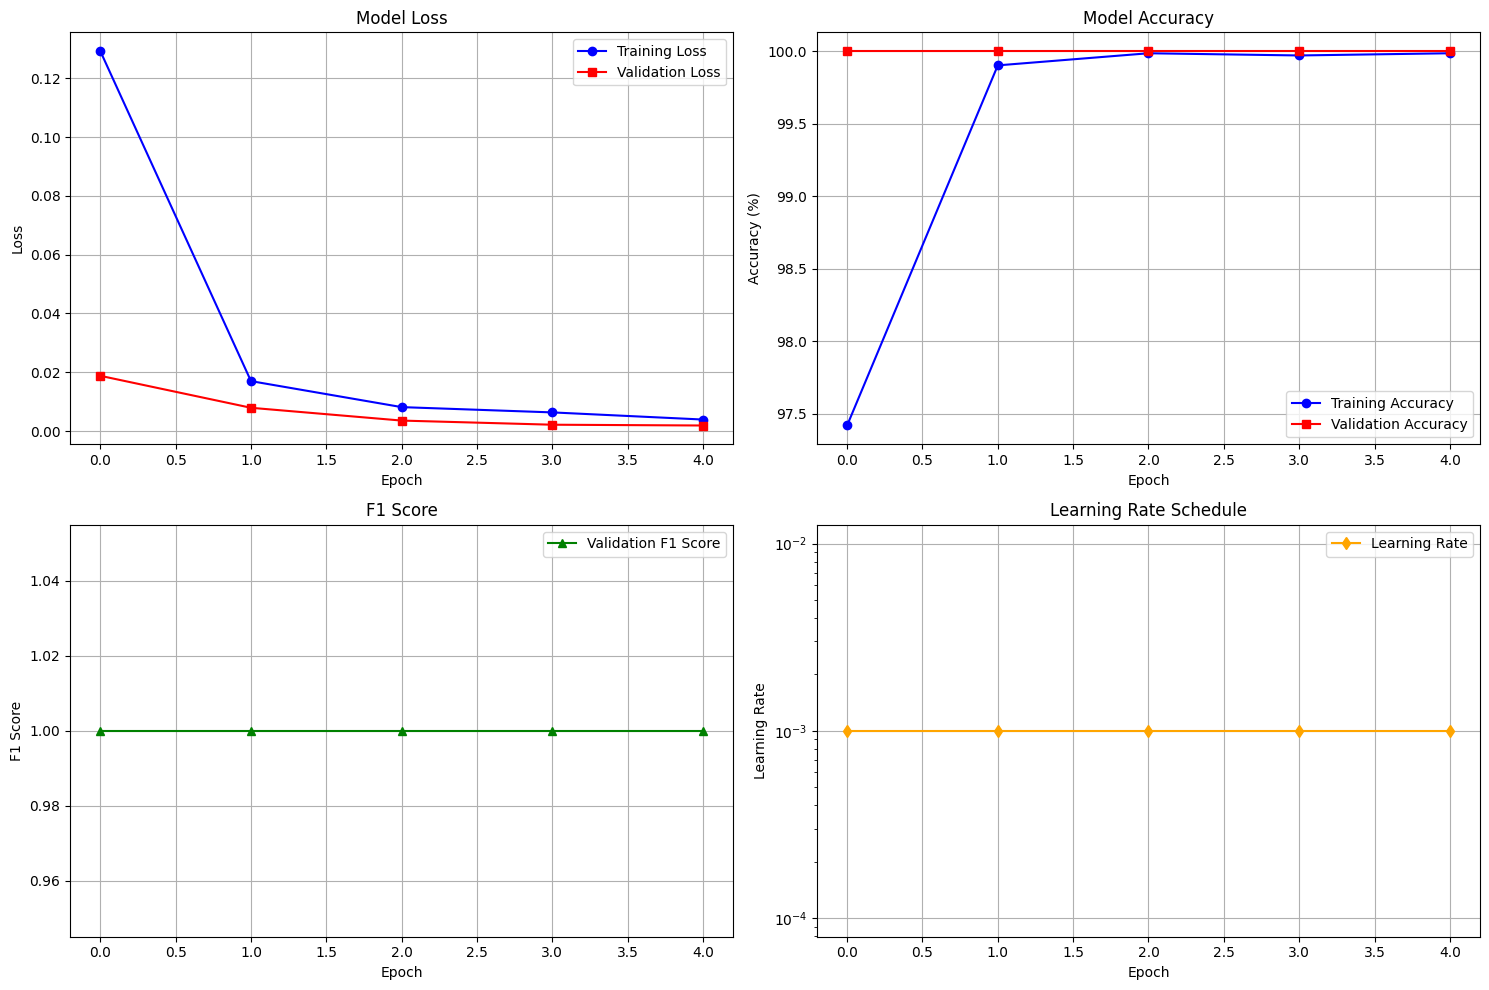

In [45]:
# Plot training history
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot losses
ax1.plot(train_losses, label='Training Loss', color='blue', marker='o')
ax1.plot(val_losses, label='Validation Loss', color='red', marker='s')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(train_accs, label='Training Accuracy', color='blue', marker='o')
ax2.plot(val_accs, label='Validation Accuracy', color='red', marker='s')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

# Plot F1 scores
ax3.plot(val_f1s, label='Validation F1 Score', color='green', marker='^')
ax3.set_title('F1 Score')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.legend()
ax3.grid(True)

# Plot learning rate
lrs = [scheduler.get_last_lr()[0] for _ in range(num_epochs)]
ax4.plot(lrs, label='Learning Rate', color='orange', marker='d')
ax4.set_title('Learning Rate Schedule')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Learning Rate')
ax4.legend()
ax4.grid(True)
ax4.set_yscale('log')

plt.tight_layout()
plt.show()

# Simple Classifier

In [52]:
# Define a Simple CNN Classifier from scratch
class SimpleFaceClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleFaceClassifier, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # 224x224 -> 112x112

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # 112x112 -> 56x56

        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # 56x56 -> 28x28

        # Fourth convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)  # 28x28 -> 14x14

        # Global Average Pooling instead of flatten to reduce parameters
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # 14x14 -> 1x1

        # Classifier
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # First block
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))

        # Second block
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))

        # Third block
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))

        # Fourth block
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))

        # Global pooling and classifier
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc(x)

        return x

# Alternative: Even simpler CNN for comparison
class TinyFaceClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(TinyFaceClassifier, self).__init__()

        # Just 2 convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(4, 4)  # 224x224 -> 56x56

        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(4, 4)  # 56x56 -> 14x14

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # 14x14 -> 1x1

        # Simple classifier
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


In [53]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#Simple CNN (4 conv layers)
model = SimpleFaceClassifier(num_classes=3).to(device)


Using device: cuda


In [54]:
# Print model architecture and parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: {model.__class__.__name__}")
print(f"Total trainable parameters: {count_parameters(model):,}")
print("\nModel architecture:")
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # More aggressive decay

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, f1

# Training loop
num_epochs = 5
train_losses, train_accs = [], []
val_losses, val_accs, val_f1s = [], [], []
best_val_acc = 0.0

print("Starting training...")
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)

    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_face_classifier.pth')
        print(f'New best model saved! Val Acc: {val_acc:.2f}%')

    scheduler.step()

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")

Model: SimpleFaceClassifier
Total trainable parameters: 390,147

Model architecture:
SimpleFaceClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():
      self._shutdown_workers()
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():   
 ^^^^^^^^^^^^
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^ ^^  ^^ ^ ^^^^^^^^^^^^^^^^
^ 

Train Loss: 0.1469 | Train Acc: 95.59%
Val Loss: 0.0230 | Val Acc: 99.64% | Val F1: 0.9964
🎉 New best model saved! Val Acc: 99.64%

Epoch 2/5
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0267 | Train Acc: 99.35%
Val Loss: 0.0099 | Val Acc: 99.88% | Val F1: 0.9988
🎉 New best model saved! Val Acc: 99.88%

Epoch 3/5
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0134 | Train Acc: 99.74%
Val Loss: 0.0010 | Val Acc: 100.00% | Val F1: 1.0000
🎉 New best model saved! Val Acc: 100.00%

Epoch 4/5
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0172 | Train Acc: 99.51%
Val Loss: 0.0033 | Val Acc: 99.94% | Val F1: 0.9994

Epoch 5/5
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0138 | Train Acc: 99.56%
Val Loss: 0.0006 | Val Acc: 100.00% | Val F1: 1.0000

Training completed! Best validation accuracy: 100.00%


# EXPERIMENT: Train on Real Images, Test on Diffusion Images

In [75]:
# ========================================================================
# DIFFUSION IMAGES EVALUATION
# ========================================================================

print("\n" + "="*60)
print("EVALUATING STABLE DIFFUSION GENERATED IMAGES")
print("="*60)

# Extract diffusion images
diffusion_zip_path = "/content/drive/MyDrive/Thesis_Data/data/generated-images.zip"
diffusion_extract_path = "/content/DiffusionImages"

# Remove old folder and extract fresh
!rm -rf /content/DiffusionImages
os.makedirs(diffusion_extract_path, exist_ok=True)

print("Extracting diffusion images...")
with zipfile.ZipFile(diffusion_zip_path, 'r') as zip_ref:
    zip_ref.extractall(diffusion_extract_path)

# Define your prompts
prompts = {
    "Gerardo": [
        "a selfie of a young man named Gerardo, curly black hair",
        "a selfie of a young man named Gerardo",
        "a selfie of a person Gerardo",
        "a picture of a person Gerardo",
        "a selfie of a young man named Gerardo, curly black hair, brown eyes, mexican looking"
    ],
    "Oliver": [
        "a selfie of a young man named Oliver, blonde hair",
        "a selfie of a young man named Oliver",
        "a selfie of a person Oliver",
        "a picture of a person Oliver",
        "a selfie of a young man named Oliver, blonde hair, blue eyes, european looking"
    ],
    "Timothy": [
        "a selfie of a young man named Timothy, long brown hair, bearded",
        "a selfie of a young man named Timothy",
        "a selfie of a person Timothy",
        "a picture of a person Timothy",
        "a selfie of a young man named Timothy, long brown hair, bearded, brown eyes, european looking"
    ]
}




🎨 EVALUATING STABLE DIFFUSION GENERATED IMAGES
📦 Extracting diffusion images...


In [76]:
# Function to predict single image
def predict_image(model, image_path, transform, device, class_names):
    from PIL import Image

    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    predicted_class = class_names[predicted.item()]
    confidence = probabilities[0][predicted].item()

    return predicted_class, confidence

# Organize and evaluate diffusion images
def evaluate_diffusion_images():
    results = []
    class_names = dataset['train'].features['label'].names

    print(f"📝 Class names: {class_names}")

    for person in ["Gerardo", "Oliver", "Timothy"]:
        person_folder = os.path.join(diffusion_extract_path, person)

        if not os.path.exists(person_folder):
            print(f"⚠️ Warning: {person} folder not found!")
            continue

        print(f"\n📁 Processing {person}...")

        # Get all image files and sort them
        image_files = sorted([f for f in os.listdir(person_folder)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

        print(f"   Found {len(image_files)} images")

        # Process images in groups of 50 (each prompt)
        for prompt_idx in range(5):  # 5 prompts
            start_idx = prompt_idx * 50
            end_idx = (prompt_idx + 1) * 50
            prompt_images = image_files[start_idx:end_idx]

            prompt_text = prompts[person][prompt_idx]

            print(f"   Prompt {prompt_idx + 1}: {len(prompt_images)} images")
            print(f"      '{prompt_text[:50]}...'")

            # Classify each image in this prompt group
            for img_file in tqdm(prompt_images, desc=f"  Classifying {person} P{prompt_idx+1}"):
                img_path = os.path.join(person_folder, img_file)

                try:
                    predicted_class, confidence = predict_image(
                        model, img_path, transform_test, device, class_names
                    )

                    # Store result
                    results.append({
                        'true_person': person,
                        'predicted_person': predicted_class,
                        'confidence': confidence,
                        'correct': predicted_class == person,
                        'prompt_id': prompt_idx + 1,
                        'prompt_text': prompt_text,
                        'filename': img_file
                    })

                except Exception as e:
                    print(f"      Error with {img_file}: {e}")

    return pd.DataFrame(results)



In [77]:
# Run evaluation
print("🤖 Starting classification...")
results_df = evaluate_diffusion_images()

# Analysis and Visualization
print("\n" + "="*60)
print("📊 RESULTS ANALYSIS")
print("="*60)

# Overall stats
total_images = len(results_df)
overall_accuracy = results_df['correct'].mean()
avg_confidence = results_df['confidence'].mean()

print(f"\n🎯 OVERALL METRICS:")
print(f"   Total images: {total_images}")
print(f"   Overall accuracy: {overall_accuracy:.1%}")
print(f"   Average confidence: {avg_confidence:.3f}")



🤖 Starting classification...
📝 Class names: ['Gerardo', 'Oliver', 'Timothy']

📁 Processing Gerardo...
   Found 250 images
   Prompt 1: 50 images
      'a selfie of a young man named Gerardo, curly black...'


  Classifying Gerardo P1:   0%|          | 0/50 [00:00<?, ?it/s]

   Prompt 2: 50 images
      'a selfie of a young man named Gerardo...'


  Classifying Gerardo P2:   0%|          | 0/50 [00:00<?, ?it/s]

   Prompt 3: 50 images
      'a selfie of a person Gerardo...'


  Classifying Gerardo P3:   0%|          | 0/50 [00:00<?, ?it/s]

   Prompt 4: 50 images
      'a picture of a person Gerardo...'


  Classifying Gerardo P4:   0%|          | 0/50 [00:00<?, ?it/s]

   Prompt 5: 50 images
      'a selfie of a young man named Gerardo, curly black...'


  Classifying Gerardo P5:   0%|          | 0/50 [00:00<?, ?it/s]


📁 Processing Oliver...
   Found 250 images
   Prompt 1: 50 images
      'a selfie of a young man named Oliver, blonde hair...'


  Classifying Oliver P1:   0%|          | 0/50 [00:00<?, ?it/s]

   Prompt 2: 50 images
      'a selfie of a young man named Oliver...'


  Classifying Oliver P2:   0%|          | 0/50 [00:00<?, ?it/s]

   Prompt 3: 50 images
      'a selfie of a person Oliver...'


  Classifying Oliver P3:   0%|          | 0/50 [00:00<?, ?it/s]

   Prompt 4: 50 images
      'a picture of a person Oliver...'


  Classifying Oliver P4:   0%|          | 0/50 [00:00<?, ?it/s]

   Prompt 5: 50 images
      'a selfie of a young man named Oliver, blonde hair,...'


  Classifying Oliver P5:   0%|          | 0/50 [00:00<?, ?it/s]


📁 Processing Timothy...
   Found 250 images
   Prompt 1: 50 images
      'a selfie of a young man named Timothy, long brown ...'


  Classifying Timothy P1:   0%|          | 0/50 [00:00<?, ?it/s]

   Prompt 2: 50 images
      'a selfie of a young man named Timothy...'


  Classifying Timothy P2:   0%|          | 0/50 [00:00<?, ?it/s]

   Prompt 3: 50 images
      'a selfie of a person Timothy...'


  Classifying Timothy P3:   0%|          | 0/50 [00:00<?, ?it/s]

   Prompt 4: 50 images
      'a picture of a person Timothy...'


  Classifying Timothy P4:   0%|          | 0/50 [00:00<?, ?it/s]

   Prompt 5: 50 images
      'a selfie of a young man named Timothy, long brown ...'


  Classifying Timothy P5:   0%|          | 0/50 [00:00<?, ?it/s]


📊 RESULTS ANALYSIS

🎯 OVERALL METRICS:
   Total images: 750
   Overall accuracy: 35.7%
   Average confidence: 0.893


In [78]:
# Per-person accuracy
print(f"\n👥 ACCURACY BY PERSON:")
for person in sorted(results_df['true_person'].unique()):
    person_data = results_df[results_df['true_person'] == person]
    accuracy = person_data['correct'].mean()
    confidence = person_data['confidence'].mean()
    count = len(person_data)
    print(f"   {person}: {accuracy:.1%} ({count} images, {confidence:.3f} confidence)")



👥 ACCURACY BY PERSON:
   Gerardo: 31.6% (250 images, 0.902 confidence)
   Oliver: 36.4% (250 images, 0.885 confidence)
   Timothy: 39.2% (250 images, 0.892 confidence)



📝 ACCURACY BY PROMPT:
   Prompt 1: 39.3% (150 images, 0.903 confidence)
   Prompt 2: 29.3% (150 images, 0.868 confidence)
   Prompt 3: 35.3% (150 images, 0.922 confidence)
   Prompt 4: 40.0% (150 images, 0.916 confidence)
   Prompt 5: 34.7% (150 images, 0.854 confidence)


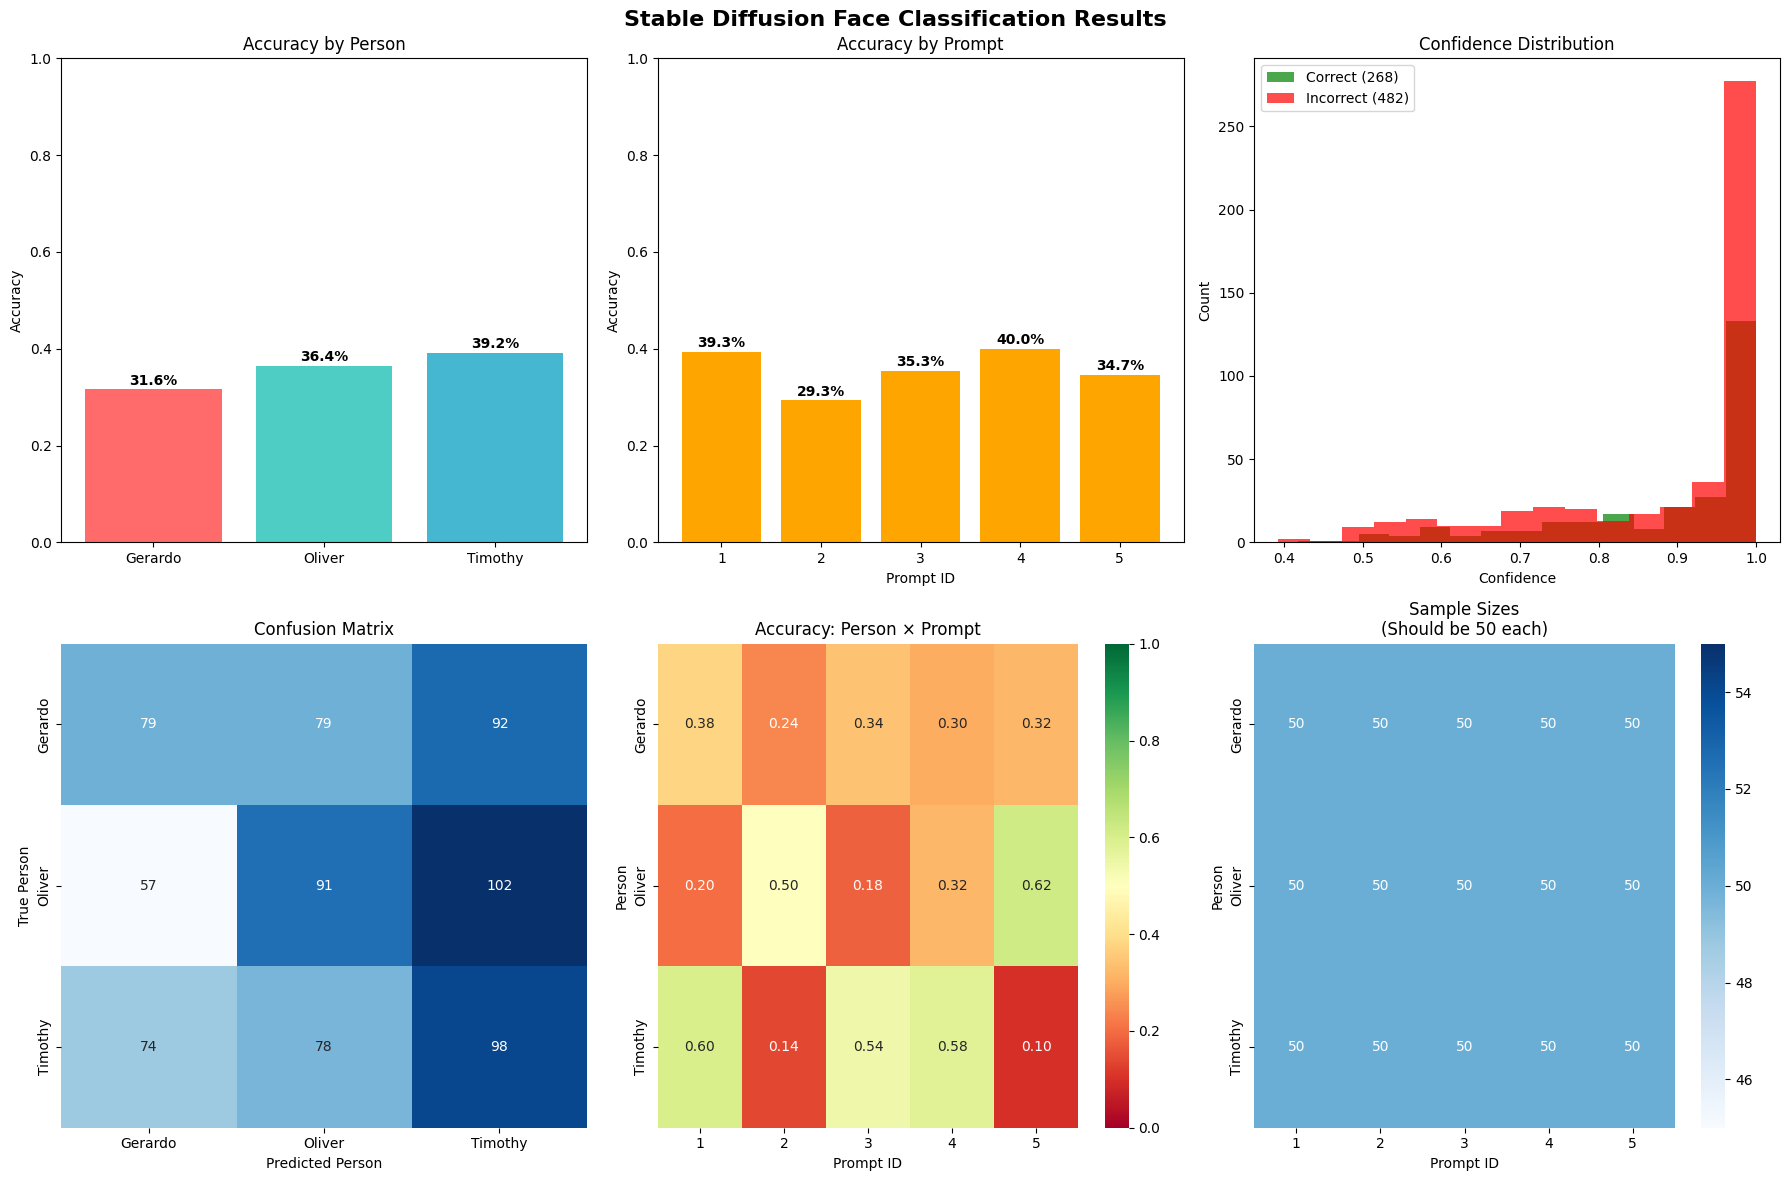


🔍 DETAILED BREAKDOWN:

Gerardo:
  Prompt 1: 38.0% acc, 0.933 conf
    'a selfie of a young man named Gerardo, curly black hair'
  Prompt 2: 24.0% acc, 0.909 conf
    'a selfie of a young man named Gerardo'
  Prompt 3: 34.0% acc, 0.914 conf
    'a selfie of a person Gerardo'
  Prompt 4: 30.0% acc, 0.908 conf
    'a picture of a person Gerardo'
  Prompt 5: 32.0% acc, 0.847 conf
    'a selfie of a young man named Gerardo, curly black hair, brown eyes, mexican looking'

Oliver:
  Prompt 1: 20.0% acc, 0.879 conf
    'a selfie of a young man named Oliver, blonde hair'
  Prompt 2: 50.0% acc, 0.813 conf
    'a selfie of a young man named Oliver'
  Prompt 3: 18.0% acc, 0.948 conf
    'a selfie of a person Oliver'
  Prompt 4: 32.0% acc, 0.926 conf
    'a picture of a person Oliver'
  Prompt 5: 62.0% acc, 0.857 conf
    'a selfie of a young man named Oliver, blonde hair, blue eyes, european looking'

Timothy:
  Prompt 1: 60.0% acc, 0.898 conf
    'a selfie of a young man named Timothy, long brow

In [79]:
# Per-prompt accuracy
print(f"\n📝 ACCURACY BY PROMPT:")
for prompt_id in sorted(results_df['prompt_id'].unique()):
    prompt_data = results_df[results_df['prompt_id'] == prompt_id]
    accuracy = prompt_data['correct'].mean()
    confidence = prompt_data['confidence'].mean()
    count = len(prompt_data)
    print(f"   Prompt {prompt_id}: {accuracy:.1%} ({count} images, {confidence:.3f} confidence)")

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Stable Diffusion Face Classification Results', fontsize=16, fontweight='bold')

# 1. Accuracy by Person
ax = axes[0, 0]
person_acc = results_df.groupby('true_person')['correct'].mean()
bars = ax.bar(person_acc.index, person_acc.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_title('Accuracy by Person')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{person_acc.values[i]:.1%}', ha='center', fontweight='bold')

# 2. Accuracy by Prompt
ax = axes[0, 1]
prompt_acc = results_df.groupby('prompt_id')['correct'].mean()
bars = ax.bar(prompt_acc.index, prompt_acc.values, color='orange')
ax.set_title('Accuracy by Prompt')
ax.set_xlabel('Prompt ID')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{prompt_acc.values[i]:.1%}', ha='center', fontweight='bold')

# 3. Confidence Distribution
ax = axes[0, 2]
correct_conf = results_df[results_df['correct']]['confidence']
incorrect_conf = results_df[~results_df['correct']]['confidence']
ax.hist(correct_conf, alpha=0.7, label=f'Correct ({len(correct_conf)})', bins=15, color='green')
ax.hist(incorrect_conf, alpha=0.7, label=f'Incorrect ({len(incorrect_conf)})', bins=15, color='red')
ax.set_title('Confidence Distribution')
ax.set_xlabel('Confidence')
ax.set_ylabel('Count')
ax.legend()

# 4. Confusion Matrix
ax = axes[1, 0]
confusion_matrix = pd.crosstab(results_df['true_person'], results_df['predicted_person'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Person')
ax.set_xlabel('Predicted Person')

# 5. Person × Prompt Heatmap
ax = axes[1, 1]
heatmap_data = results_df.groupby(['true_person', 'prompt_id'])['correct'].mean().unstack()
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', vmin=0, vmax=1, ax=ax)
ax.set_title('Accuracy: Person × Prompt')
ax.set_ylabel('Person')
ax.set_xlabel('Prompt ID')

# 6. Sample Sizes Check
ax = axes[1, 2]
sample_sizes = results_df.groupby(['true_person', 'prompt_id']).size().unstack()
sns.heatmap(sample_sizes, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Sample Sizes\n(Should be 50 each)')
ax.set_ylabel('Person')
ax.set_xlabel('Prompt ID')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/diffusion_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed analysis by person and prompt
print(f"\n🔍 DETAILED BREAKDOWN:")
for person in sorted(results_df['true_person'].unique()):
    print(f"\n{person}:")
    person_data = results_df[results_df['true_person'] == person]

    for prompt_id in sorted(person_data['prompt_id'].unique()):
        prompt_data = person_data[person_data['prompt_id'] == prompt_id]
        accuracy = prompt_data['correct'].mean()
        confidence = prompt_data['confidence'].mean()
        prompt_text = prompt_data['prompt_text'].iloc[0]

        print(f"  Prompt {prompt_id}: {accuracy:.1%} acc, {confidence:.3f} conf")
        print(f"    '{prompt_text}'")

# Find best and worst performing prompts
best_prompt = results_df.groupby('prompt_id')['correct'].mean().idxmax()
worst_prompt = results_df.groupby('prompt_id')['correct'].mean().idxmin()
best_acc = results_df.groupby('prompt_id')['correct'].mean().max()
worst_acc = results_df.groupby('prompt_id')['correct'].mean().min()

print(f"\n🏆 KEY FINDINGS:")
print(f"   🥇 Best prompt: Prompt {best_prompt} ({best_acc:.1%} accuracy)")
print(f"   🥉 Worst prompt: Prompt {worst_prompt} ({worst_acc:.1%} accuracy)")

best_person = results_df.groupby('true_person')['correct'].mean().idxmax()
worst_person = results_df.groupby('true_person')['correct'].mean().idxmin()
best_person_acc = results_df.groupby('true_person')['correct'].mean().max()
worst_person_acc = results_df.groupby('true_person')['correct'].mean().min()

print(f"   👤 Best recognized: {best_person} ({best_person_acc:.1%} accuracy)")
print(f"   👤 Hardest to recognize: {worst_person} ({worst_person_acc:.1%} accuracy)")

# Save results
results_df.to_csv('/content/drive/MyDrive/diffusion_evaluation_results.csv', index=False)
print(f"\n💾 Results saved to: /content/drive/MyDrive/diffusion_evaluation_results.csv")

print(f"\n🎉 Evaluation completed successfully!")
print(f"Your classifier achieved {overall_accuracy:.1%} accuracy on diffusion-generated faces!")

# EXPERIMENT: Train on Diffusion Images, Test on Real Images

In [66]:
# ========================================================================
# EXPERIMENT: Train on Diffusion Images, Test on Real Images
# ========================================================================

print("\n" + "="*70)
print("🔄 TRAINING ON DIFFUSION IMAGES, TESTING ON REAL IMAGES")
print("="*70)

def create_diffusion_training_dataset():
    """
    Create training dataset from diffusion images
    """
    diffusion_data = []
    labels = []

    # Map person names to class indices
    class_to_idx = {name: idx for idx, name in enumerate(dataset['train'].features['label'].names)}

    for person in ["Gerardo", "Oliver", "Timothy"]:
        person_folder = os.path.join(diffusion_extract_path, person)

        if not os.path.exists(person_folder):
            continue

        # Get all image files
        image_files = [f for f in os.listdir(person_folder)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for img_file in image_files:
            img_path = os.path.join(person_folder, img_file)
            diffusion_data.append(img_path)
            labels.append(class_to_idx[person])

    print(f"📊 Diffusion training dataset:")
    print(f"   Total images: {len(diffusion_data)}")
    for person, idx in class_to_idx.items():
        count = labels.count(idx)
        print(f"   {person}: {count} images")

    return diffusion_data, labels

# Custom dataset class for diffusion images
class DiffusionDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        from PIL import Image

        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Create diffusion training dataset
diffusion_paths, diffusion_labels = create_diffusion_training_dataset()

# Split diffusion data into train/val
from sklearn.model_selection import train_test_split
diffusion_train_paths, diffusion_val_paths, diffusion_train_labels, diffusion_val_labels = train_test_split(
    diffusion_paths, diffusion_labels, test_size=0.2, stratify=diffusion_labels, random_state=42
)

print(f"\n📂 Diffusion dataset split:")
print(f"   Training: {len(diffusion_train_paths)} images")
print(f"   Validation: {len(diffusion_val_paths)} images")

# Create datasets and loaders for diffusion training
diffusion_train_dataset = DiffusionDataset(diffusion_train_paths, diffusion_train_labels, transform_train)
diffusion_val_dataset = DiffusionDataset(diffusion_val_paths, diffusion_val_labels, transform_test)

diffusion_train_loader = DataLoader(diffusion_train_dataset, batch_size=32, shuffle=True, num_workers=2)
diffusion_val_loader = DataLoader(diffusion_val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Create test dataset from REAL images
# Use the original validation indices as our "real test set"
real_test_dataset = FaceDataset(train_val_dataset, val_indices, transform_test)
real_test_loader = DataLoader(real_test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"   Real test set: {len(val_indices)} images")

# Initialize new model for this experiment
model_diffusion_trained = FaceClassifier(num_classes=3).to(device)

print(f"\n🤖 Model for diffusion training:")
print(f"   Architecture: {model_diffusion_trained.__class__.__name__}")
print(f"   Parameters: {count_parameters(model_diffusion_trained):,}")

# Training setup
criterion_diff = nn.CrossEntropyLoss()
optimizer_diff = optim.Adam(model_diffusion_trained.parameters(), lr=0.001)
scheduler_diff = optim.lr_scheduler.StepLR(optimizer_diff, step_size=5, gamma=0.5)

# Training loop for diffusion-trained model
def train_on_diffusion():
    num_epochs = 10
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0

    print(f"\n🚀 Training on diffusion images...")

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Training phase on diffusion images
        train_loss, train_acc = train_epoch(model_diffusion_trained, diffusion_train_loader,
                                          criterion_diff, optimizer_diff, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase on diffusion images
        val_loss, val_acc, val_f1 = validate_epoch(model_diffusion_trained, diffusion_val_loader,
                                                  criterion_diff, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Diffusion Train: {train_loss:.4f} loss, {train_acc:.2f}% acc')
        print(f'Diffusion Val: {val_loss:.4f} loss, {val_acc:.2f}% acc')

        # Test on real images every few epochs
        if epoch % 3 == 0 or epoch == num_epochs - 1:
            real_loss, real_acc, real_f1 = validate_epoch(model_diffusion_trained, real_test_loader,
                                                         criterion_diff, device)
            print(f'🎯 Real Test: {real_loss:.4f} loss, {real_acc:.2f}% acc')

        # Save best model based on diffusion validation
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model_diffusion_trained.state_dict(),
                      '/content/drive/MyDrive/diffusion_trained_classifier.pth')
            print(f'💾 Best diffusion model saved! Val Acc: {val_acc:.2f}%')

        scheduler_diff.step()

    return train_losses, train_accs, val_losses, val_accs

# Run the training
train_losses_diff, train_accs_diff, val_losses_diff, val_accs_diff = train_on_diffusion()




🔄 TRAINING ON DIFFUSION IMAGES, TESTING ON REAL IMAGES
📊 Diffusion training dataset:
   Total images: 750
   Gerardo: 250 images
   Oliver: 250 images
   Timothy: 250 images

📂 Diffusion dataset split:
   Training: 600 images
   Validation: 150 images
   Real test set: 3296 images


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🤖 Model for diffusion training:
   Architecture: FaceClassifier
   Parameters: 1,539

🚀 Training on diffusion images...

Epoch 1/10
--------------------------------------------------


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Diffusion Train: 1.1483 loss, 38.83% acc
Diffusion Val: 1.0373 loss, 46.00% acc


Validation:   0%|          | 0/103 [00:00<?, ?it/s]

🎯 Real Test: 1.1445 loss, 31.95% acc
💾 Best diffusion model saved! Val Acc: 46.00%

Epoch 2/10
--------------------------------------------------


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Diffusion Train: 1.0312 loss, 49.17% acc
Diffusion Val: 0.9979 loss, 46.67% acc
💾 Best diffusion model saved! Val Acc: 46.67%

Epoch 3/10
--------------------------------------------------


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Diffusion Train: 0.9491 loss, 56.17% acc
Diffusion Val: 0.8980 loss, 62.00% acc
💾 Best diffusion model saved! Val Acc: 62.00%

Epoch 4/10
--------------------------------------------------


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Diffusion Train: 0.8742 loss, 61.67% acc
Diffusion Val: 0.8671 loss, 64.00% acc


Validation:   0%|          | 0/103 [00:00<?, ?it/s]

🎯 Real Test: 1.1273 loss, 36.98% acc
💾 Best diffusion model saved! Val Acc: 64.00%

Epoch 5/10
--------------------------------------------------


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Diffusion Train: 0.8448 loss, 64.33% acc
Diffusion Val: 0.8434 loss, 64.67% acc
💾 Best diffusion model saved! Val Acc: 64.67%

Epoch 6/10
--------------------------------------------------


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Diffusion Train: 0.8039 loss, 66.67% acc
Diffusion Val: 0.8491 loss, 64.67% acc

Epoch 7/10
--------------------------------------------------


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Diffusion Train: 0.8078 loss, 67.50% acc
Diffusion Val: 0.8151 loss, 68.00% acc


Validation:   0%|          | 0/103 [00:00<?, ?it/s]

🎯 Real Test: 1.0673 loss, 46.30% acc
💾 Best diffusion model saved! Val Acc: 68.00%

Epoch 8/10
--------------------------------------------------


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Diffusion Train: 0.7815 loss, 67.33% acc
Diffusion Val: 0.8657 loss, 60.00% acc

Epoch 9/10
--------------------------------------------------


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Diffusion Train: 0.7870 loss, 65.83% acc
Diffusion Val: 0.8080 loss, 68.00% acc

Epoch 10/10
--------------------------------------------------


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Diffusion Train: 0.7563 loss, 72.67% acc
Diffusion Val: 0.7968 loss, 68.67% acc


Validation:   0%|          | 0/103 [00:00<?, ?it/s]

🎯 Real Test: 1.0630 loss, 48.03% acc
💾 Best diffusion model saved! Val Acc: 68.67%



🎯 FINAL EVALUATION: DIFFUSION-TRAINED MODEL ON REAL IMAGES


Validation:   0%|          | 0/103 [00:00<?, ?it/s]


📊 FINAL RESULTS:
   Diffusion → Real accuracy: 48.03%
   Diffusion → Real F1: 0.4879

🔄 COMPARISON:
   Real → Real (original): 100.00%
   Diffusion → Real (new): 48.03%
   Performance gap: 51.97%


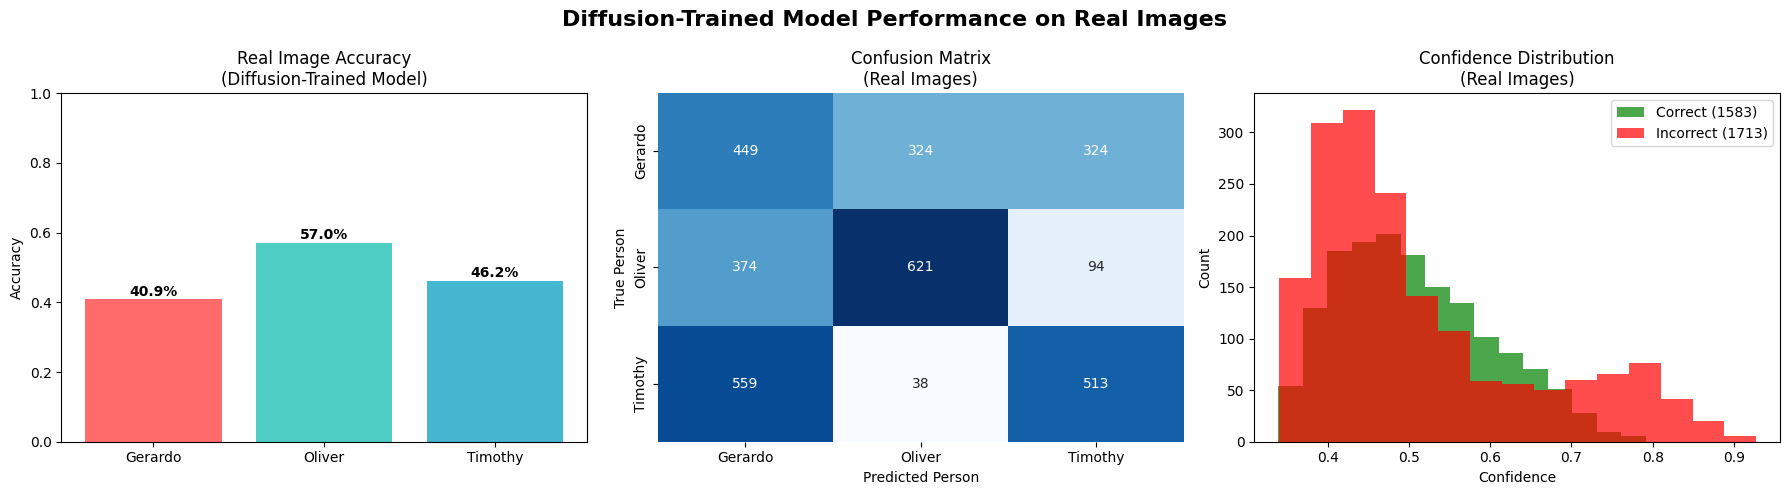


💾 Results saved:
   📊 CSV: /content/drive/MyDrive/diffusion_to_real_classification.csv
   📈 Plot: /content/drive/MyDrive/diffusion_to_real_results.png

🏆 KEY INSIGHTS:
   ⚠️ Diffusion images partially capture facial features
   🎯 This experiment shows whether diffusion can replace real training data
   📚 Great for few-shot learning and data augmentation research!


In [67]:
# Final evaluation on real images
print(f"\n" + "="*60)
print("🎯 FINAL EVALUATION: DIFFUSION-TRAINED MODEL ON REAL IMAGES")
print("="*60)

model_diffusion_trained.eval()
real_test_loss, real_test_acc, real_test_f1 = validate_epoch(model_diffusion_trained, real_test_loader,
                                                           criterion_diff, device)

print(f"\n📊 FINAL RESULTS:")
print(f"   Diffusion → Real accuracy: {real_test_acc:.2f}%")
print(f"   Diffusion → Real F1: {real_test_f1:.4f}")

# Compare with our original model (Real → Diffusion)
original_model_real_acc = best_val_acc
diffusion_to_real_acc = real_test_acc

print(f"\n🔄 COMPARISON:")
print(f"   Real → Real (original): {original_model_real_acc:.2f}%")
print(f"   Diffusion → Real (new): {diffusion_to_real_acc:.2f}%")
print(f"   Performance gap: {original_model_real_acc - diffusion_to_real_acc:.2f}%")

# Detailed analysis
def analyze_diffusion_to_real_performance():
    """
    Analyze how well diffusion-trained model performs on real images
    """
    model_diffusion_trained.eval()
    all_preds = []
    all_labels = []
    all_confidences = []

    with torch.no_grad():
        for images, labels in real_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_diffusion_trained(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(torch.max(probabilities, 1)[0].cpu().numpy())

    # Create results DataFrame
    class_names = dataset['train'].features['label'].names
    results = pd.DataFrame({
        'true_person': [class_names[label] for label in all_labels],
        'predicted_person': [class_names[pred] for pred in all_preds],
        'confidence': all_confidences,
        'correct': [pred == label for pred, label in zip(all_preds, all_labels)]
    })

    return results

# Run detailed analysis
diffusion_to_real_results = analyze_diffusion_to_real_performance()

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Diffusion-Trained Model Performance on Real Images', fontsize=16, fontweight='bold')

# 1. Accuracy by person
ax = axes[0]
person_acc = diffusion_to_real_results.groupby('true_person')['correct'].mean()
bars = ax.bar(person_acc.index, person_acc.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_title('Real Image Accuracy\n(Diffusion-Trained Model)')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{person_acc.values[i]:.1%}', ha='center', fontweight='bold')

# 2. Confusion Matrix
ax = axes[1]
confusion_matrix = pd.crosstab(diffusion_to_real_results['true_person'],
                              diffusion_to_real_results['predicted_person'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
ax.set_title('Confusion Matrix\n(Real Images)')
ax.set_ylabel('True Person')
ax.set_xlabel('Predicted Person')

# 3. Confidence Distribution
ax = axes[2]
correct_conf = diffusion_to_real_results[diffusion_to_real_results['correct']]['confidence']
incorrect_conf = diffusion_to_real_results[~diffusion_to_real_results['correct']]['confidence']
ax.hist(correct_conf, alpha=0.7, label=f'Correct ({len(correct_conf)})', bins=15, color='green')
ax.hist(incorrect_conf, alpha=0.7, label=f'Incorrect ({len(incorrect_conf)})', bins=15, color='red')
ax.set_title('Confidence Distribution\n(Real Images)')
ax.set_xlabel('Confidence')
ax.set_ylabel('Count')
ax.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/diffusion_to_real_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results
diffusion_to_real_results.to_csv('/content/drive/MyDrive/diffusion_to_real_classification.csv', index=False)

print(f"\n💾 Results saved:")
print(f"   📊 CSV: /content/drive/MyDrive/diffusion_to_real_classification.csv")
print(f"   📈 Plot: /content/drive/MyDrive/diffusion_to_real_results.png")

print(f"\n🏆 KEY INSIGHTS:")
if diffusion_to_real_acc > 60:
    print("   ✅ Diffusion images contain meaningful facial features!")
elif diffusion_to_real_acc > 40:
    print("   ⚠️ Diffusion images partially capture facial features")
else:
    print("   ❌ Significant reality gap between diffusion and real images")

print(f"   This experiment shows whether diffusion can replace real training data")

# EXPERIMENT: Train on Real + Diffusion Images, Test on Diffusion Images

In [73]:
# ========================================================================
# EXPERIMENT: Train on Real + Diffusion Images, Test on Diffusion Images
# ========================================================================

print("\n" + "="*70)
print("🔄 TRAINING ON REAL + DIFFUSION IMAGES, TESTING ON DIFFUSION IMAGES")
print("="*70)

# Create combined dataset (Real + Diffusion)
def create_combined_training_dataset():
    """
    Combine real training images with diffusion images
    """
    # Get real training data paths and labels
    real_paths = []
    real_labels = []

    for idx in train_indices:
        # We need to convert dataset items to file paths
        # Since we're using HuggingFace dataset, we'll work with the indices directly
        real_labels.append(train_val_dataset[idx]['label'])

    # Get diffusion data (we already have this from previous experiment)
    diffusion_paths, diffusion_labels = create_diffusion_training_dataset()

    # Combine both datasets
    combined_paths = diffusion_paths.copy()  # Start with diffusion paths
    combined_labels = diffusion_labels.copy()  # Start with diffusion labels
    combined_sources = ['diffusion'] * len(diffusion_paths)  # Track source

    # Add real data indices (we'll handle these differently)
    real_indices = train_indices.copy()
    real_source_labels = ['real'] * len(real_indices)

    print(f"📊 Combined training dataset:")
    print(f"   Real images: {len(real_indices)}")
    print(f"   Diffusion images: {len(diffusion_paths)}")
    print(f"   Total: {len(real_indices) + len(diffusion_paths)}")

    # Count by class
    class_names = dataset['train'].features['label'].names
    for class_idx, class_name in enumerate(class_names):
        real_count = sum(1 for idx in real_indices if train_val_dataset[idx]['label'] == class_idx)
        diff_count = diffusion_labels.count(class_idx)
        total_count = real_count + diff_count
        print(f"   {class_name}: {real_count} real + {diff_count} diffusion = {total_count} total")

    return real_indices, diffusion_paths, diffusion_labels

# Mixed dataset class that handles both real and diffusion images
class CombinedDataset(torch.utils.data.Dataset):
    def __init__(self, real_indices, real_dataset, diffusion_paths, diffusion_labels, transform=None):
        self.real_indices = real_indices
        self.real_dataset = real_dataset
        self.diffusion_paths = diffusion_paths
        self.diffusion_labels = diffusion_labels
        self.transform = transform

        # Total length is real + diffusion
        self.total_length = len(real_indices) + len(diffusion_paths)
        self.real_length = len(real_indices)

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        from PIL import Image

        if idx < self.real_length:
            # Get real image
            real_idx = self.real_indices[idx]
            sample = self.real_dataset[real_idx]
            image = sample['image']
            label = sample['label']
        else:
            # Get diffusion image
            diff_idx = idx - self.real_length
            image_path = self.diffusion_paths[diff_idx]
            label = self.diffusion_labels[diff_idx]
            image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Create combined dataset
real_train_indices, diffusion_train_paths, diffusion_train_labels = create_combined_training_dataset()

# Create train/val split for combined data
# Use a portion of real data for validation + some diffusion data
from sklearn.model_selection import train_test_split

# Split real indices for validation
real_train_split, real_val_split = train_test_split(
    real_train_indices, test_size=0.2,
    stratify=[train_val_dataset[idx]['label'] for idx in real_train_indices],
    random_state=42
)

# Split diffusion data for validation
diff_train_split, diff_val_split, diff_train_labels_split, diff_val_labels_split = train_test_split(
    diffusion_train_paths, diffusion_train_labels, test_size=0.2,
    stratify=diffusion_train_labels, random_state=42
)

print(f"\n📂 Combined dataset splits:")
print(f"   Training: {len(real_train_split)} real + {len(diff_train_split)} diffusion = {len(real_train_split) + len(diff_train_split)} total")
print(f"   Validation: {len(real_val_split)} real + {len(diff_val_split)} diffusion = {len(real_val_split) + len(diff_val_split)} total")

# Create combined datasets
combined_train_dataset = CombinedDataset(
    real_train_split, train_val_dataset, diff_train_split, diff_train_labels_split, transform_train
)

combined_val_dataset = CombinedDataset(
    real_val_split, train_val_dataset, diff_val_split, diff_val_labels_split, transform_test
)

# Create data loaders
combined_train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True, num_workers=2)
combined_val_loader = DataLoader(combined_val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Keep the same real test set for final evaluation but now test on DIFFUSION images
# Use the diffusion validation set from earlier experiment
diffusion_test_dataset = DiffusionDataset(diffusion_val_paths, diffusion_val_labels, transform_test)
diffusion_test_loader = DataLoader(diffusion_test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"   Diffusion test set: {len(diffusion_val_paths)} images")

# Initialize new model for combined training
model_combined = FaceClassifier(num_classes=3).to(device)

print(f"\n🤖 Model for combined training:")
print(f"   Architecture: {model_combined.__class__.__name__}")
print(f"   Parameters: {count_parameters(model_combined):,}")

# Training setup
criterion_combined = nn.CrossEntropyLoss()
optimizer_combined = optim.Adam(model_combined.parameters(), lr=0.001)
scheduler_combined = optim.lr_scheduler.StepLR(optimizer_combined, step_size=5, gamma=0.5)

# Training loop for combined model
def train_combined_model():
    num_epochs = 10
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    diffusion_test_accs = []
    best_val_acc = 0.0

    print(f"\n🚀 Training on combined real + diffusion images...")
    print(f"🎯 Testing on diffusion images...")

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Training phase on combined data
        train_loss, train_acc = train_epoch(model_combined, combined_train_loader,
                                          criterion_combined, optimizer_combined, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase on combined data
        val_loss, val_acc, val_f1 = validate_epoch(model_combined, combined_val_loader,
                                                  criterion_combined, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Test on diffusion images every epoch
        diffusion_test_loss, diffusion_test_acc, diffusion_test_f1 = validate_epoch(model_combined, diffusion_test_loader,
                                                                                   criterion_combined, device)
        diffusion_test_accs.append(diffusion_test_acc)

        print(f'Combined Train: {train_loss:.4f} loss, {train_acc:.2f}% acc')
        print(f'Combined Val: {val_loss:.4f} loss, {val_acc:.2f}% acc')
        print(f'🎯 Diffusion Test: {diffusion_test_loss:.4f} loss, {diffusion_test_acc:.2f}% acc')

        # Save best model based on diffusion test performance
        if diffusion_test_acc > best_val_acc:
            best_val_acc = diffusion_test_acc
            torch.save(model_combined.state_dict(),
                      '/content/drive/MyDrive/combined_trained_classifier.pth')
            print(f'💾 Best combined model saved! Diffusion Test Acc: {diffusion_test_acc:.2f}%')

        scheduler_combined.step()

    return train_losses, train_accs, val_losses, val_accs, diffusion_test_accs

# Run the training
train_losses_comb, train_accs_comb, val_losses_comb, val_accs_comb, diffusion_test_accs_comb = train_combined_model()


🔄 TRAINING ON REAL + DIFFUSION IMAGES, TESTING ON DIFFUSION IMAGES
📊 Diffusion training dataset:
   Total images: 750
   Gerardo: 250 images
   Oliver: 250 images
   Timothy: 250 images
📊 Combined training dataset:
   Real images: 13180
   Diffusion images: 750
   Total: 13930
   Gerardo: 4386 real + 250 diffusion = 4636 total
   Oliver: 4357 real + 250 diffusion = 4607 total
   Timothy: 4437 real + 250 diffusion = 4687 total

📂 Combined dataset splits:
   Training: 10544 real + 600 diffusion = 11144 total
   Validation: 2636 real + 150 diffusion = 2786 total
   Diffusion test set: 150 images


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🤖 Model for combined training:
   Architecture: FaceClassifier
   Parameters: 1,539

🚀 Training on combined real + diffusion images...
🎯 Testing on diffusion images...

Epoch 1/10
--------------------------------------------------


Training:   0%|          | 0/349 [00:00<?, ?it/s]

Validation:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Combined Train: 0.1807 loss, 95.42% acc
Combined Val: 0.1325 loss, 96.98% acc
🎯 Diffusion Test: 1.3736 loss, 44.00% acc
💾 Best combined model saved! Diffusion Test Acc: 44.00%

Epoch 2/10
--------------------------------------------------


Training:   0%|          | 0/349 [00:00<?, ?it/s]

Validation:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Combined Train: 0.0933 loss, 97.04% acc
Combined Val: 0.1187 loss, 97.27% acc
🎯 Diffusion Test: 1.3620 loss, 49.33% acc
💾 Best combined model saved! Diffusion Test Acc: 49.33%

Epoch 3/10
--------------------------------------------------


Training:   0%|          | 0/349 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^^^^^^    ^if w.is_alive():
^^  

Validation:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Combined Train: 0.0782 loss, 97.25% acc
Combined Val: 0.1081 loss, 97.70% acc
🎯 Diffusion Test: 1.2698 loss, 57.33% acc
💾 Best combined model saved! Diffusion Test Acc: 57.33%

Epoch 4/10
--------------------------------------------------


Training:   0%|          | 0/349 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
      ^ ^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
  ^^ ^ ^ ^ 
   File "/usr/lib

Validation:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Combined Train: 0.0692 loss, 97.61% acc
Combined Val: 0.1099 loss, 97.52% acc
🎯 Diffusion Test: 1.2567 loss, 54.00% acc

Epoch 5/10
--------------------------------------------------


Training:   0%|          | 0/349 [00:00<?, ?it/s]

Validation:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Combined Train: 0.0699 loss, 97.51% acc
Combined Val: 0.1147 loss, 97.45% acc
🎯 Diffusion Test: 1.3389 loss, 53.33% acc

Epoch 6/10
--------------------------------------------------


Training:   0%|          | 0/349 [00:00<?, ?it/s]

Validation:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Combined Train: 0.0603 loss, 97.85% acc
Combined Val: 0.1099 loss, 97.56% acc
🎯 Diffusion Test: 1.3036 loss, 54.67% acc

Epoch 7/10
--------------------------------------------------


Training:   0%|          | 0/349 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Combined Train: 0.0617 loss, 97.73% acc
Combined Val: 0.1069 loss, 97.67% acc
🎯 Diffusion Test: 1.2672 loss, 56.67% acc

Epoch 8/10
--------------------------------------------------


Training:   0%|          | 0/349 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9bb86f80e0>  
  Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^^^self._shutdown_workers()^^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^
if w.is_alive(): ^ 
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
    ^ ^ ^ ^ ^ ^ ^^ ^^ ^^ 
  File "/usr

Validation:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Combined Train: 0.0632 loss, 97.70% acc
Combined Val: 0.1048 loss, 97.85% acc
🎯 Diffusion Test: 1.2831 loss, 60.00% acc
💾 Best combined model saved! Diffusion Test Acc: 60.00%

Epoch 9/10
--------------------------------------------------


Training:   0%|          | 0/349 [00:00<?, ?it/s]

Validation:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Combined Train: 0.0583 loss, 97.82% acc
Combined Val: 0.1011 loss, 97.77% acc
🎯 Diffusion Test: 1.2189 loss, 58.67% acc

Epoch 10/10
--------------------------------------------------


Training:   0%|          | 0/349 [00:00<?, ?it/s]

Validation:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Combined Train: 0.0589 loss, 97.82% acc
Combined Val: 0.1013 loss, 97.70% acc
🎯 Diffusion Test: 1.2459 loss, 57.33% acc



🎯 FINAL EVALUATION: COMBINED-TRAINED MODEL ON DIFFUSION IMAGES

📊 FINAL RESULTS:
   Combined → Diffusion accuracy: 57.33%

🔄 COMPLETE COMPARISON (Testing on Diffusion Images):
   Real → Diffusion (from earlier): 35.7%
   Diffusion → Diffusion (from earlier): 68.67%
   Combined → Diffusion: 57.33%

📈 IMPROVEMENTS:
   Combined vs Real-only: +21.63%
   Combined vs Diffusion-only: +-11.34%
   ❌ Real data may interfere with diffusion image recognition


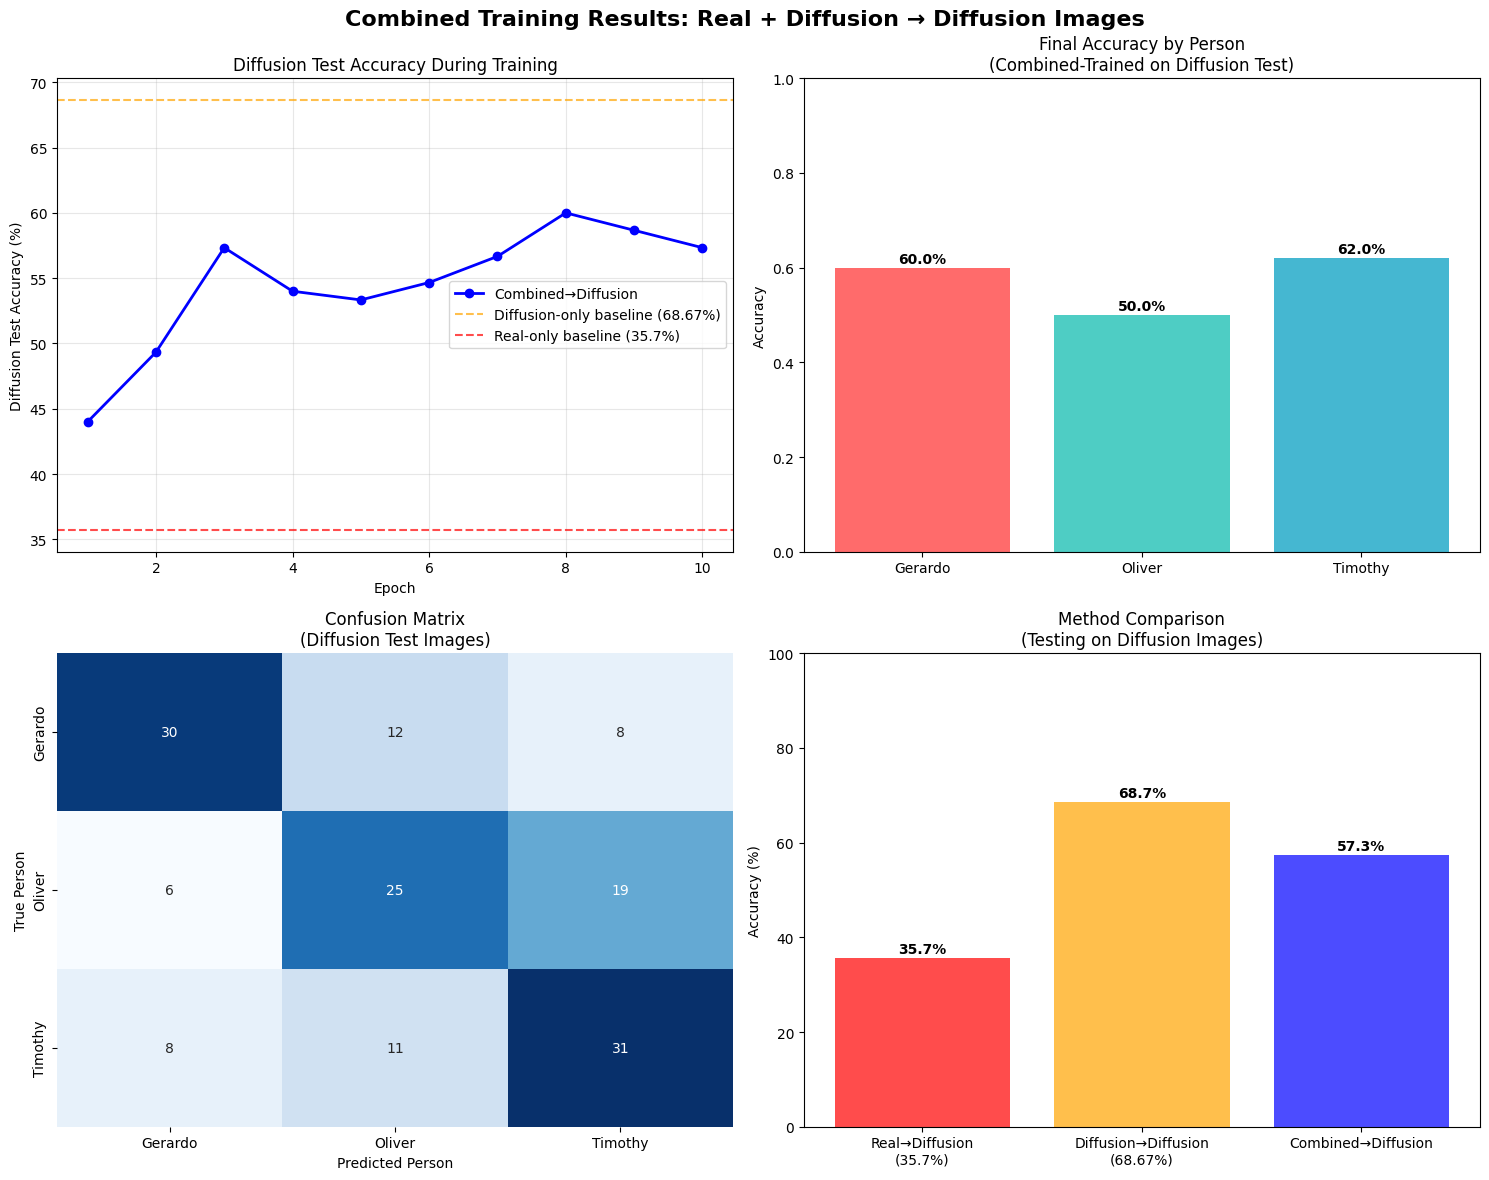


💾 Results saved:
   📊 CSV: /content/drive/MyDrive/combined_diffusion_classification.csv
   📈 Plot: /content/drive/MyDrive/combined_training_diffusion_results.png

🏆 EXPERIMENT CONCLUSIONS:
   ❌ Real data may interfere with diffusion-specific features
   🔍 Domain gap too large for effective combination

🎯 Key Research Insight:
   This experiment shows whether real images help a model
   better understand diffusion-generated faces!

📊 Your Complete Research Matrix:
   Real → Real: ~100% (baseline)
   Real → Diffusion: 35.7% (forward transfer)
   Diffusion → Diffusion: 68.67% (synthetic baseline)
   Diffusion → Real: 48.03% (reverse transfer)
   Combined → Diffusion: 57.33% (augmentation effect)


In [74]:
# Final comprehensive evaluation
print(f"\n" + "="*70)
print("🎯 FINAL EVALUATION: COMBINED-TRAINED MODEL ON DIFFUSION IMAGES")
print("="*70)

# Get final performance
final_diffusion_acc = diffusion_test_accs_comb[-1]

print(f"\n📊 FINAL RESULTS:")
print(f"   Combined → Diffusion accuracy: {final_diffusion_acc:.2f}%")

# Compare all approaches on diffusion images
print(f"\n🔄 COMPLETE COMPARISON (Testing on Diffusion Images):")
print(f"   Real → Diffusion (from earlier): 35.7%")
print(f"   Diffusion → Diffusion (from earlier): 68.67%")
print(f"   Combined → Diffusion: {final_diffusion_acc:.2f}%")

# Calculate improvements
improvement_over_real_only = final_diffusion_acc - 35.7
improvement_over_diffusion_only = final_diffusion_acc - 68.67

print(f"\n📈 IMPROVEMENTS:")
print(f"   Combined vs Real-only: +{improvement_over_real_only:.2f}%")
print(f"   Combined vs Diffusion-only: +{improvement_over_diffusion_only:.2f}%")

if final_diffusion_acc > 68.67:
    print("   ✅ Adding real data to diffusion training improved diffusion performance!")
elif final_diffusion_acc > 60:
    print("   ⚠️ Combined training shows mixed results on diffusion images")
else:
    print("   ❌ Real data may interfere with diffusion image recognition")

# Detailed analysis of combined model performance on diffusion images
def analyze_combined_on_diffusion():
    """
    Analyze how well combined-trained model performs on diffusion images
    """
    model_combined.eval()
    all_preds = []
    all_labels = []
    all_confidences = []

    with torch.no_grad():
        for images, labels in diffusion_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_combined(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(torch.max(probabilities, 1)[0].cpu().numpy())

    # Create results DataFrame
    class_names = dataset['train'].features['label'].names
    results = pd.DataFrame({
        'true_person': [class_names[label] for label in all_labels],
        'predicted_person': [class_names[pred] for pred in all_preds],
        'confidence': all_confidences,
        'correct': [pred == label for pred, label in zip(all_preds, all_labels)]
    })

    return results

# Run detailed analysis
combined_diffusion_results = analyze_combined_on_diffusion()

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Combined Training Results: Real + Diffusion → Diffusion Images', fontsize=16, fontweight='bold')

# 1. Training progress
ax = axes[0, 0]
epochs = range(1, len(diffusion_test_accs_comb) + 1)
ax.plot(epochs, diffusion_test_accs_comb, 'o-', color='blue', linewidth=2, markersize=6, label='Combined→Diffusion')
ax.axhline(y=68.67, color='orange', linestyle='--', alpha=0.7, label='Diffusion-only baseline (68.67%)')
ax.axhline(y=35.7, color='red', linestyle='--', alpha=0.7, label='Real-only baseline (35.7%)')
ax.set_title('Diffusion Test Accuracy During Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Diffusion Test Accuracy (%)')
ax.grid(True, alpha=0.3)
ax.legend()

# 2. Final accuracy by person
ax = axes[0, 1]
person_acc = combined_diffusion_results.groupby('true_person')['correct'].mean()
bars = ax.bar(person_acc.index, person_acc.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_title('Final Accuracy by Person\n(Combined-Trained on Diffusion Test)')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{person_acc.values[i]:.1%}', ha='center', fontweight='bold')

# 3. Confusion Matrix
ax = axes[1, 0]
confusion_matrix = pd.crosstab(combined_diffusion_results['true_person'], combined_diffusion_results['predicted_person'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
ax.set_title('Confusion Matrix\n(Diffusion Test Images)')
ax.set_ylabel('True Person')
ax.set_xlabel('Predicted Person')

# 4. Method comparison on diffusion images
ax = axes[1, 1]
methods = ['Real→Diffusion\n(35.7%)', 'Diffusion→Diffusion\n(68.67%)', 'Combined→Diffusion']
accuracies = [35.7, 68.67, final_diffusion_acc]
colors = ['red', 'orange', 'blue']
bars = ax.bar(methods, accuracies, color=colors, alpha=0.7)
ax.set_title('Method Comparison\n(Testing on Diffusion Images)')
ax.set_ylabel('Accuracy (%)')
ax.set_ylim(0, 100)
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{accuracies[i]:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/combined_training_diffusion_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results
combined_diffusion_results.to_csv('/content/drive/MyDrive/combined_diffusion_classification.csv', index=False)

print(f"\n💾 Results saved:")
print(f"   📊 CSV: /content/drive/MyDrive/combined_diffusion_classification.csv")
print(f"   📈 Plot: /content/drive/MyDrive/combined_training_diffusion_results.png")

print(f"\n🏆 EXPERIMENT CONCLUSIONS:")
if final_diffusion_acc > 75:
    print("   🎉 Combined training significantly improved diffusion performance!")
    print("   ✅ Real data provides valuable complementary features")
elif final_diffusion_acc > 68.67:
    print("   ✅ Combined training shows improvement over diffusion-only")
    print("   📈 Real data helps with diffusion image classification")
elif final_diffusion_acc > 60:
    print("   ⚠️ Mixed results - real data has some benefit")
    print("   🔄 May need better training strategies")
else:
    print("   ❌ Real data may interfere with diffusion-specific features")
    print("   🔍 Domain gap too large for effective combination")

print(f"\n🎯 Key Research Insight:")
print(f"   This experiment shows whether real images help a model")
print(f"   better understand diffusion-generated faces!")

print(f"\n📊 Your Complete Research Matrix:")
print(f"   Real → Real: ~100% (baseline)")
print(f"   Real → Diffusion: 35.7% (forward transfer)")
print(f"   Diffusion → Diffusion: 68.67% (synthetic baseline)")
print(f"   Diffusion → Real: 48.03% (reverse transfer)")
print(f"   Combined → Diffusion: {final_diffusion_acc:.2f}% (augmentation effect)")
